# Part 1: Load and Read Data

In [1]:
import pandas as pd

# Load dataset and remove duplicates
df = pd.read_csv('./IMDB-Dataset.csv')
df = df.drop_duplicates()

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Part 2: Data Preprocessing

In [4]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

nltk.download('stopwords')
nltk.download('wordnet')

stop = set(stopwords.words('english'))
wl = WordNetLemmatizer()

def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = expand_contractions(text)
    
    # Updated regex for removing emojis
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags
                             u"\u2600-\u26FF"          # miscellaneous symbols
                             u"\u2700-\u27BF"          # dingbats
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    
    text = re.sub(r'\.(?=\S)', '. ', text)
    text = re.sub(r'http\S+', '', text)
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])
    
    return text

df['review'] = df['review'].apply(preprocess_text)

df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DuyTuan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DuyTuan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\DuyTuan\AppData\Local\Temp\ipykernel_10872\3191486024.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


# Part 3: Data Analysis

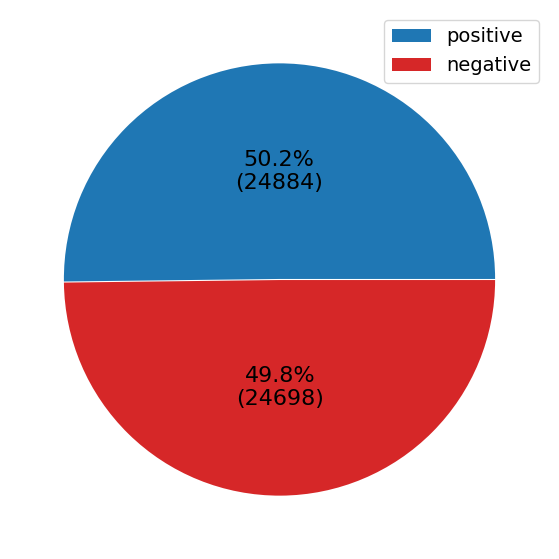

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*np.sum(data))})",
        explode=[0.0025]*2, pctdistance=0.5, colors=[sns.color_palette()[0],'tab:red'],
        textprops={'fontsize': 16})
plt.legend(labels, loc="best", prop={'size': 14})
plt.show()


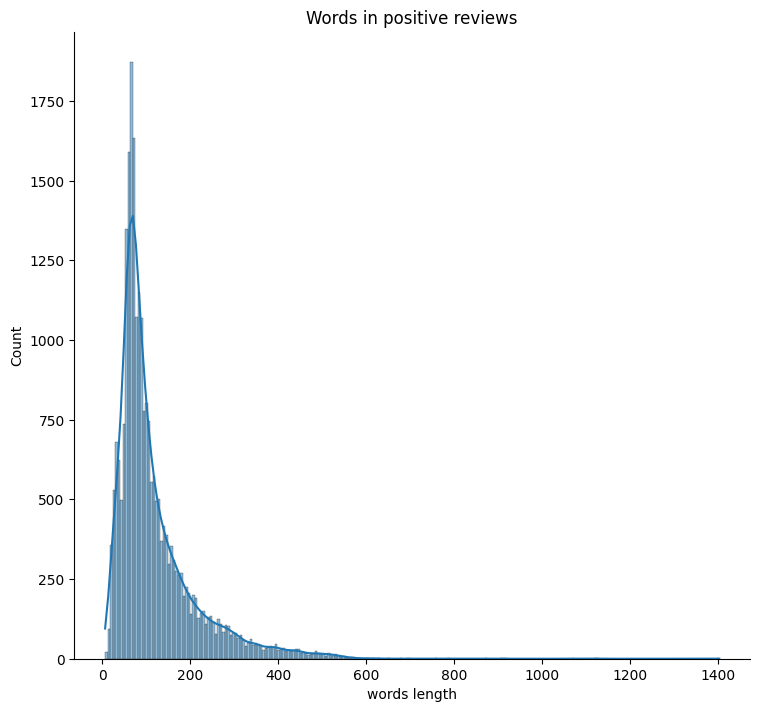

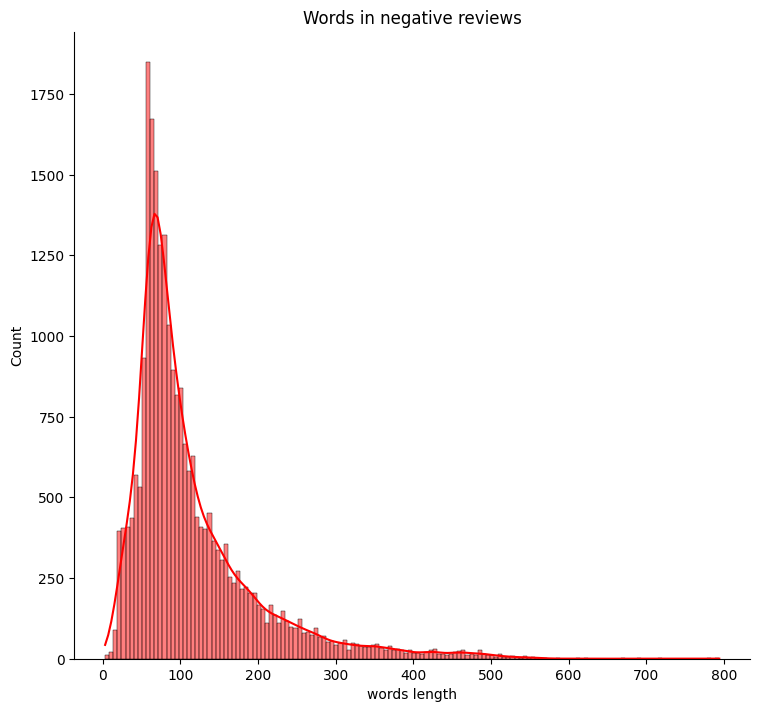

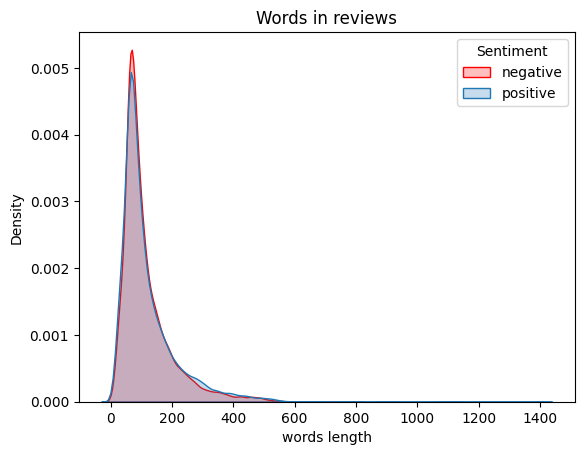

In [6]:
df_temp = df.copy()
df_temp['words length'] = df['review'].str.split().map(lambda x: len(x))

hist_positive = sns.displot(data=df_temp[df_temp['sentiment'] == 'positive'],
                            x="words length", hue="sentiment", kde=True,
                            height=7, aspect=1.1, legend=False)
plt.title('Words in positive reviews')
plt.show()

hist_negative = sns.displot(data=df_temp[df_temp['sentiment'] == 'negative'],
                            x="words length", hue="sentiment", kde=True,
                            height=7, aspect=1.1, legend=False, palette=['red'])
plt.title('Words in negative reviews')
plt.show()

kernel_distibution_number_words_plot = sns.kdeplot(data=df_temp, x="words length", hue="sentiment",
                                                   fill=True, palette=[sns.color_palette()[0],'red'])
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.title('Words in reviews')
plt.show()


# Part 4: Split Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x_data = df['review']
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)


# Part 5: Text Vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)


# Part 6: Model Training and Evaluation

## Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Decision Tree
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(x_train_encoded, y_train)
y_pred_dt = dt_classifier.predict(x_test_encoded)
accuracy_dt = accuracy_score(y_pred_dt, y_test)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")


Decision Tree Accuracy: 0.71


## Random Forest Classifier

In [10]:
# Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred_rf = rf_classifier.predict(x_test_encoded)
accuracy_rf = accuracy_score(y_pred_rf, y_test)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")


Random Forest Accuracy: 0.84
